position reconstruction with taylor (padding PMT pos and dir)

In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
f = h5py.File('/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo/e-/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

In [4]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [5]:
event_data.shape

(3000, 126, 126, 2)

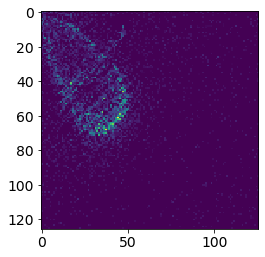

In [6]:
plt.imshow(event_data[2,:,:,0])

In [7]:
mGridCoords = np.stack([
    f['mGridX'][()]/1000.,
    f['mGridY'][()]/1000.,
    f['mGridZ'][()]/1000.,
    f['mGridDirX'][()]*3.,
    f['mGridDirY'][()]*3.,
    f['mGridDirZ'][()]*3.
],2).astype(np.float32)
mGridCoords.shape

(126, 126, 6)

In [8]:
mGridCoords.dtype

dtype('float32')

In [9]:
np.stack([mGridCoords]).shape

(1, 126, 126, 6)

In [10]:
np.broadcast_to(mGridCoords, (3000,126,126,6)).shape

(3000, 126, 126, 6)

In [11]:
(event_data.shape[0],)+mGridCoords.shape

(3000, 126, 126, 6)

In [12]:
np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape).shape

(3000, 126, 126, 6)

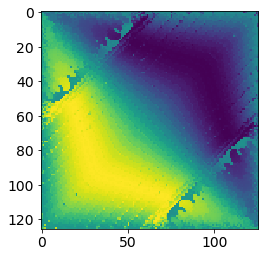

In [13]:
plt.imshow(np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape)[2,:,:,0])

In [14]:
np.concatenate([event_data, np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape)],3).shape

(3000, 126, 126, 8)

In [15]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

## Taylor prep

In [16]:
class Taylorizer:
    """Perform taylor expansion of tensor using pre-computed expansion weights"""
    def __init__(self, mGridPmt, mGridCoord, vectorStartIndices, pad=1, Lambda=0.5):
        """
        mGridPmt:   numpy array with (Height,Width) only significance is
                    1. value should be unique for each grid site
                    2. if no PMT exists, set to -1
        mGridCoord: numpy array with (Ncoords,Height,Width)
        vectorStartIndices: array with the start indices of xyz vectors in Ncoords, e.g.
                            for [x,y,z,dirx,diry,dirz] pass [0,3] which treats (x,y,z) and (dirx,diry,dirz)
                            as a vector
        pad:        the taylor expansion will be performed on a grid with sides 2*pad+1
        Lambda:     the regularization strength. should be something of order the differences in mGridCoord
        """
        
        self.mGridPmt   = mGridPmt
        self.mGridCoord = mGridCoord
        self.vectorStartIndices = vectorStartIndices
        self.pad = pad
        self.Lambda = Lambda
        self.rotPhi = 0.
        self.AA = self.computeTaylorWeights()
    
    def cuda(self):
        self.AA = self.AA.cuda()
    
    def cpu(self):
        self.AA = self.AA.cpu()
        
    def __call__(self, inputs):
        return self.taylorize(inputs)

    def computeTaylorWeights(self):
        pad = self.pad
        mGridPmt = self.mGridPmt
        mGridCoord = self.mGridCoord

        Ncoords = mGridCoord.shape[0]
        Ntaylor = 1 + Ncoords # + (Ncoords*(Ncoords+1))//2
        self.Ntaylor = Ntaylor

        M = mGridPmt.shape[0]
        mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
        mGridJ = mGridI.transpose()

        Nshift = 2*pad+1
        dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
        dis = dij.flatten()
        djs = dij.transpose().flatten();
        Nsites = dis.size;
        
        self.dis = dis
        self.djs = djs
        self.Nsites = Nsites

        mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

        mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


        mGridAA2 = np.zeros((M,M,Nshift,Nshift,Ntaylor))

        pmtI1 = mGridPmt[:,:]; # index in tank.pmt

        x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
        skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
        processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

        for diji in range(Nsites):
            di = dis[diji]
            dj = djs[diji]
            # i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            # j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            pmtI2 = mGridPmtpad[(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)];
            processedPmtI2s[:,:,diji] = pmtI2;

            skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
            for prev_diji in range(diji):
                skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));

            x[:,:,:,diji] = mGridCoordPad[:,(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)] - mGridCoord; # 

        # x: (Ncoords,M,M,Nsites)
        # print('x.shape:', x.shape)
        # X: (Ntaylor,M,M,Nsites)
        Xlist = [np.expand_dims(np.ones(x.shape[1:]),0),x]
        #for i in range(Ncoords):
        #    Xlist.append(np.stack([x[i,:,:,:] for j in range(Ncoords-i)]) * x[i:,:,:,:])
        X = np.concatenate(Xlist)
        # print('X.shape:', X.shape)
        X = np.where(np.expand_dims(skip, 0), 0., X);

        # regularization strength
        Lambda = self.Lambda; # this should be somewhat smaller than typical values of x

        MA = np.zeros((M,M,Nsites,Nsites));
        for k in range(Nsites):
            for j in range(Nsites):
                MA[:,:,k,j] = np.add(np.sum(X[:,:,:,k]*X[:,:,:,j], axis=0), Lambda**2 * (k==j));
            # clear skip entries
            MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
            MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
            # set diagonal:
            MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

        #print('MA.shape:',MA.shape)
        #print(MA[0,1,:,:])
        #print(np.linalg.inv(MA[0,1,:,:]))
        print("starting inversion... (may take a few seconds)")
        AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
        print("done")
        # print('AA.shape:', AA.shape)
        return torch.tensor(AA, dtype=torch.float)
    
    def taylorize(self, inputs):
        Batches = inputs.shape[0]
        ChIn    = inputs.shape[1]
        Height  = inputs.shape[2]
        Width   = inputs.shape[3]
        tGridAA = self.AA

        inputsPad = geometricPad(inputs, self.pad); # (B,C,W,H)
        # tayloredInput = inputs.new_zeros((Batches, self.Ntaylor, ChIn, Height, Width))
        
        # we use new_zeros and set diagonal to 1, because there is no new_eye method
        rotMatrix = inputs.new_zeros(self.Ntaylor, self.Ntaylor)
        for d in range(self.Ntaylor):
            rotMatrix[d,d] = 1.
        
        for startIndex in self.vectorStartIndices:
            startIndex = 1 + startIndex # the 1 is offset due to scalar
            d_x = 0
            d_y = 1
            rotMatrix[startIndex+d_x,startIndex+d_x] =  np.cos(self.rotPhi);
            rotMatrix[startIndex+d_x,startIndex+d_y] =  np.sin(self.rotPhi); # this is an inverse rotation because w is covariant
            rotMatrix[startIndex+d_y,startIndex+d_x] = -np.sin(self.rotPhi);
            rotMatrix[startIndex+d_y,startIndex+d_y] =  np.cos(self.rotPhi);
        
        #print('tGridAA.shape:', tGridAA.shape)
        #print('tayloredInput.shape:', tayloredInput.shape)
        #print('inputsPad.shape:', inputsPad.shape)
        
        # <method0> -- using for loop and narrow. quite slow
        # for k in range(self.Nsites):
        #     # shift grid according to position (without copying the data)
        #     inputsPadD1 = torch.narrow(inputsPad,   2, self.pad+int(self.dis[k]), Height)
        #     inputsPadD2 = torch.narrow(inputsPadD1, 3, self.pad+int(self.djs[k]), Width )
        #     #print('inputsPadD2.shape:', inputsPadD2.shape)
        #     # fill
        #     # d,e: directional index (Ntaylor)
        #     # i,j: grid indices
        #     # b: event in batch
        #     # c: channel
        #     
        #     # out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
        #     # tayloredInput = out
        #     
        #     # dij,bcij->bdcij
        #     tayloredInput += tGridAA[:,:,:,k].view(1, self.Ntaylor, 1, Height, Width) * inputsPadD2.view(Batches, 1, ChIn, Height, Width)
        # </method0>
        
        # inputsPad      = (B, ChIn, Height+1, Width+1)
        #print('inputsPad', inputsPad.shape, inputsPad.stride())
        inputsUnfolded = torch.nn.functional.unfold(inputsPad, kernel_size=(2*self.pad+1,2*self.pad+1))
        #print('inputsUnfolded', inputsUnfolded.shape, inputsUnfolded.stride())
        #print('tGridAA', tGridAA.shape, tGridAA.stride())
        # inputsUnfolded = (B, C*Nsites, Height*Width)
        # tGridAA = (Ntaylor, Height, Width, Nsites)
        
        # <method1> using einsum -- requires contiguous at end of function
        inputsUnfolded = inputsUnfolded.view(Batches, ChIn, self.Nsites, Height, Width)
        tayloredInput = torch.einsum('dijs,bcsij->bdcij', tGridAA, inputsUnfolded)
        # </method1>
        
        # # <method2> using matmul -- seems to blow up GPU memory
        # inputsUnfolded = inputsUnfolded.view(Batches, 1, ChIn, self.Nsites, 1, Height, Width) # bdcs1ij
        # inputsUnfolded = inputsUnfolded.permute(0, 1, 2, 5, 6, 3, 4) # bdcijs1
        # #print('inputsUnfolded after view', inputsUnfolded.shape, inputsUnfolded.stride())
        # tayloredInput = torch.matmul(
        #     tGridAA.view(1, self.Ntaylor, 1, Height, Width, 1, self.Nsites),
        #     inputsUnfolded
        # ) # bdcij1
        # tayloredInput = tayloredInput.view(Batches, self.Ntaylor, ChIn, Height, Width) # bdcij
        # # </method2>
        
        #print('tayloredInput', tayloredInput.shape, tayloredInput.stride())
        #print('target', Batches, self.Ntaylor*ChIn, Height, Width)
        
        if self.rotPhi != 0.:
            org = tayloredInput
            tayloredInput = torch.einsum('bdcij,ed->becij', org, rotMatrix).contiguous()
            #tayloredInput = out
        
        #print('tayloredInput.shape', tayloredInput.shape, 'to', (Batches, self.Ntaylor*ChIn, Height, Width))
        
        # # <method2> using matmul -- seems to blow up GPU memory
        # return tayloredInput.view(Batches, self.Ntaylor*ChIn, Height, Width)
        # # </method2>
        
        # <method1> using einsum -- requires contiguous at end of function
        # this contiguous() step is only needed when using unfold (problem is what exactly einsum does)
        return tayloredInput.contiguous().view(Batches, self.Ntaylor*ChIn, Height, Width)
        # </method1>
    
    def pool2d(self, kernel_size, stride=None, padding=0, pad=-1, Lambda=-1.):
        """
        Return new Taylorizer that can be used for the result of a 2d pool operation with given kernel size.
        kernel_size: e.g. for 2x2 max-pooling use (2,2)
        stride: defaults to kernel_size
        padding: the padding for the pool2d operation (not passed to child taylor). default: 0
        pad:    passed to child. if unset (-1)  use same as current
        Lambda: passed to child. if unset (-1.) use same as current
        """
        if stride is None:
            stride = kernel_size
        mGridPmt1    = torch.nn.functional.max_pool2d(torch.tensor(self.mGridPmt  )   .to(torch.float).unsqueeze(0), kernel_size=kernel_size, stride=stride, padding=padding).squeeze(0).to(torch.long).numpy()
        mGridFilled1 = torch.nn.functional.avg_pool2d(torch.tensor((self.mGridPmt >= 0).astype(float)).unsqueeze(0), kernel_size=kernel_size, stride=stride, padding=padding).squeeze(0).numpy()
        
        mGridCoord1 = torch.nn.functional.avg_pool2d(torch.tensor(self.mGridCoord), kernel_size=kernel_size, stride=stride, padding=padding).numpy()
        mGridCoord1 /= mGridFilled1 + 1e-6 # correct average for missing positions. the 1e-6 is to prevent division by zero
        
        if (pad < 0):
            pad = self.pad
        if (Lambda < 0.):
            Lambda = self.Lambda
        
        return Taylorizer(mGridPmt1, mGridCoord1, self.vectorStartIndices, pad=pad, Lambda=Lambda)

In [17]:
mGridPmt = f['mGridPmt'][()]
# we rotate xyz -> zxy because in IWCD tank, the y axis points along the tank axis
mGridCoord = np.stack([
    f['mGridZ'][()]/20.,
    f['mGridX'][()]/20.,
    f['mGridY'][()]/20.,
    f['mGridDirZ'][()],
    f['mGridDirX'][()],
    f['mGridDirY'][()]
])
#mGridVectorStartIndices = [0]
mGridVectorStartIndices = [0,3]

taylor0 = Taylorizer(mGridPmt, mGridCoord, mGridVectorStartIndices, pad=1, Lambda=1.)

starting inversion... (may take a few seconds)
done


0


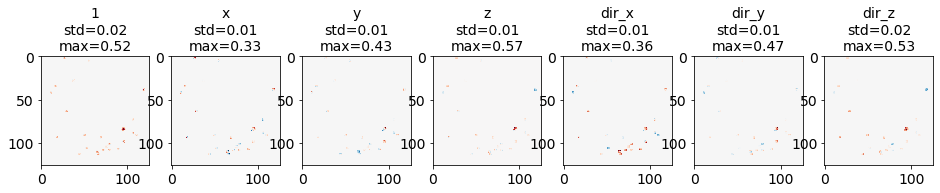

1


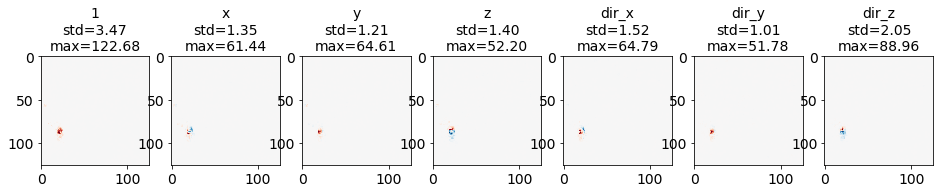

2


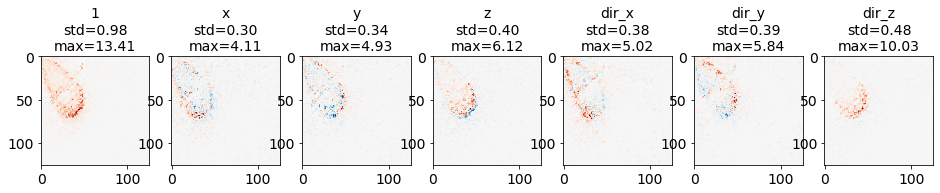

3


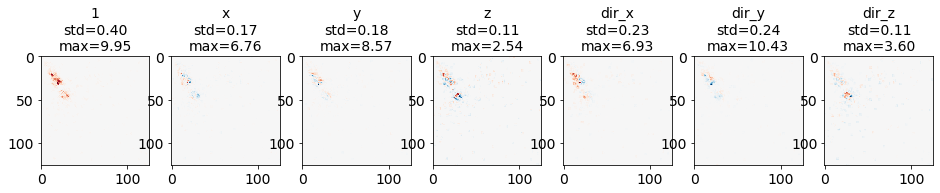

4


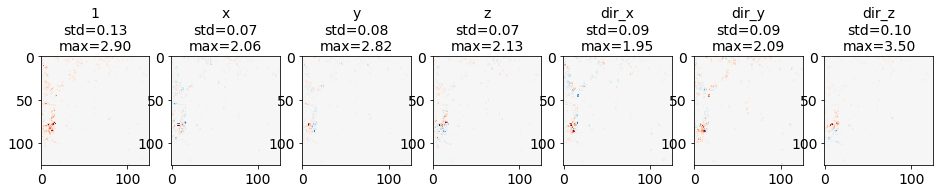

In [18]:
# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
tayloredInput = taylor0(inputs)

for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor0.Ntaylor, figsize=(16,8),facecolor='w')
    for itaylor in range(taylor0.Ntaylor):
        rms = torch.std(tayloredInput[ev,itaylor,:,:])
        ext = torch.max(torch.abs(tayloredInput[ev,itaylor,:,:]))
        imshowRdBu(axes[itaylor], tayloredInput[ev,itaylor,:,:]); axes[itaylor].set_title('%s\nstd=%.2f\nmax=%.2f' % (taylorTitles[itaylor],rms,ext))
    plt.show()

## Train network

In [19]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 0: # gamma
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        # convert event data to complex rep
        evQ = event_data[:,:,0]
        evT = event_data[:,:,1]
        evR = np.power(evQ,0.25);
        evA = 2*np.pi*(evT-960.)/(1900.-600.)
        evX = evR*np.cos(evA);
        evY = evR*np.sin(evA);
        totalQ = np.sum(evQ)
        return np.stack([evX,evY],2),label,idx,fh['positions'][entry_index,0],fh['directions'][entry_index,0],np.sum(fh['energies'][entry_index,:]),totalQ
        # the ,0 in positions and directions selects the pos/dir for the first track (in case of gamma)
        # thus positions and directions are just np arrays with 3 elements

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    pos   = np.stack([sample[3] for sample in batch])
    direc = np.stack([sample[4] for sample in batch])
    ene   = np.stack([sample[5] for sample in batch])
    totQ  = np.stack([sample[6] for sample in batch])
    return data,label,idx,pos,direc,ene,totQ

In [20]:
mcdir = '/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-','gamma')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(60) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [21]:
label,positions,directions,energies,totQs=[],[],[],[],[]
for i,data in enumerate(test_loader):
    position  = data[3]
    direction = data[4]
    energy    = data[5]
    totQ      = data[6]
    label.append(data[1])
    positions.append(position)
    directions.append(direction)
    energies.append(energy)
    totQs.append(totQ)
    if i > 50:
        break
label      = np.hstack(label)
positions  = np.vstack(positions)
directions = np.vstack(directions)
energies   = np.concatenate(energies)
totQs      = np.concatenate(totQs)

In [22]:
label.shape

(3328,)

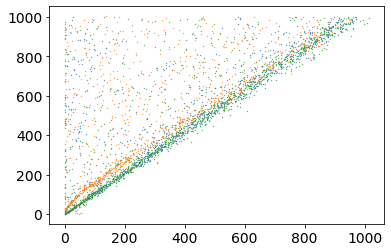

In [23]:
masses = np.array([0.511, 105.7, 0.511*2])
pthres = np.array([0.57,  118.,  0.57 *2])
Ethres = np.sqrt(np.power(masses,2) + np.power(pthres,2))

plt.scatter(totQs[label==0]*0.085, energies[label==0] - Ethres[0], s=0.1)
plt.scatter(totQs[label==1]*0.085, energies[label==1] - Ethres[1], s=0.1)
plt.scatter(totQs[label==2]*0.085, energies[label==2] - Ethres[2], s=0.1)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

# based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class TaylorBNConv2d(torch.nn.Module):
    def __init__(self, Cin, Cout, taylor, stride=1, bias=True):
        super(TaylorBNConv2d, self).__init__()
        self.stride = stride
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        #self.taylor_substitue = torch.nn.Conv2d(Cin, Cin*taylor.Ntaylor, kernel_size=3, stride=1, padding=0, bias=False)
        self.strider = torch.nn.MaxPool2d(kernel_size=1, stride=stride, padding=0)
        #self.scales = torch.nn.Parameter(torch.ones(taylor.Ntaylor))
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout, kernel_size=1, stride=1, padding=0, bias=bias)
        self.batchNorm2d = torch.nn.BatchNorm2d(Cout)
 
    def forward(self, x):
        #x = self.taylor_substitue(geometricPad(x,1))
        x = self.taylor(x)
        if self.stride > 1:
            x = self.strider(x)
        #x = self.taylor(x)
        #x = self.bn1(x)
        #if self.stride > 1:
        #    orgshape = x.shape
        #    newshape = (
        #        x.shape[0],
        #        x.shape[1],
        #        int(np.ceil(x.shape[2]/self.stride)),
        #        int(np.ceil(x.shape[3]/self.stride))
        #    )
        #    newstride = (1,1,self.stride,self.stride)
        #    x = torch.as_strided(x, newshape, newstride)
        #    #print('TaylorBNConv2d::forward: stride operation changed size from', orgshape, 'to', x.shape)
        
        # # scale the taylored dimensions
        # orgshape = x.shape
        # x = x.view(x.shape[0], self.taylor.Ntaylor, self.Cin, x.shape[2], x.shape[3])
        # scales = self.scales.view(1, self.taylor.Ntaylor, 1, 1, 1).expand(x.shape)
        # x *= scales
        # x = x.view(orgshape)
        
        x = self.conv2d(x)
        x = self.batchNorm2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorBNConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorBNConv2d, self).cuda()
        self.taylor.cuda()
        return self

# second order derivative (by stacking two first order derviatives)
class SecTaylorBNConv2d(torch.nn.Module):
    def __init__(self, Cin, Cout, taylor, stride=1, bias=True):
        super(SecTaylorBNConv2d, self).__init__()
        
        self.tbc1 = TaylorBNConv2d(Cin,  Cout, taylor, stride=1,     bias=bias)
        self.tbc2 = TaylorBNConv2d(Cout, Cout, taylor, stride=stride, bias=bias)
 
    def forward(self, x):
        x = self.tbc1(x)
        x = self.tbc2(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(SecTaylorBNConv2d, self).cpu()
        self.tbc1.cpu()
        self.tbc2.cpu()
        return self
    
    def cuda(self):
        super(SecTaylorBNConv2d, self).cuda()
        self.tbc1.cuda()
        self.tbc2.cuda()
        return self


class BasicTaylorBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, taylor1, taylor2, stride=1):
        super(BasicTaylorBlock, self).__init__()
        
        self.tbc1 = SecTaylorBNConv2d(in_planes, planes, taylor1, stride=stride, bias=False)
        self.tbc2 = SecTaylorBNConv2d(   planes, planes, taylor2, stride=1,      bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.tbc1(x))
        out = F.relu(self.tbc2(out) + self.shortcut(x))
        return out
    
    # standard implementation only calles cpu/gpu on the model's [parameters]
    # since we want it on the model itself, redefine
    
    def cpu(self):
        super(BasicTaylorBlock, self).cpu()
        self.tbc1.cpu()
        self.tbc2.cpu()
        return self
    
    def cuda(self):
        super(BasicTaylorBlock, self).cuda()
        self.tbc1.cuda()
        self.tbc2.cuda()
        return self


class ResNetTaylor(nn.Module):
    def __init__(self, block, num_blocks, taylor, num_classes=3):
        super(ResNetTaylor, self).__init__()
        self.in_planes = 64
        overall_in_planes = 2 ## this has been modified to include time
        self.pad = 1
        
        # (1,126,126)
        taylor1 = taylor
        taylor2 = taylor1.pool2d(3, stride=2, padding=1)
        taylor3 = taylor2.pool2d(3, stride=2, padding=1)
        taylor4 = taylor3.pool2d(3, stride=2, padding=1)
        taylor5 = taylor4.pool2d(3, stride=2, padding=1)
        taylor6 = taylor5.pool2d(3, stride=2, padding=1)
        
        #print('ResNetTaylor: taylor1.AA', taylor1.AA.shape)
        #print('ResNetTaylor: taylor2.AA', taylor2.AA.shape)
        #print('ResNetTaylor: taylor3.AA', taylor3.AA.shape)
        #print('ResNetTaylor: taylor4.AA', taylor4.AA.shape)
        #print('ResNetTaylor: taylor5.AA', taylor5.AA.shape)
        
        self.down1 = TaylorBNConv2d(overall_in_planes, 32, taylor1, stride=2, bias=False)
        
        # outsize = floor[(126+2*(pad=1)-(kernel_size=3))/stride + 1]
        # so for stride=1 we have 126,
        #              =2          63 = floor(63.5)
        # the padding is done by geometricPad
        # thus (16,63,63)
        
        self.down2 = TaylorBNConv2d(32, 64, taylor2, stride=2, bias=False)
        # outsize = floor[(63+2*(pad=1)-(kernel_size=3))/stride + 1]
        # so for stride=1 we have 63,
        #              =2         32
        # thus (64,32,32)
        
        self.layer1 = self._make_layer(block,  64, num_blocks[0], taylor3, taylor3, stride=1)
        #      (64,32,32)
        self.layer2 = self._make_layer(block,  64, num_blocks[1], taylor3, taylor4, stride=2)
        #      (64,16,16)
        self.layer3 = self._make_layer(block,  64, num_blocks[2], taylor4, taylor5, stride=2)
        #      (64, 8, 8)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], taylor5, taylor6, stride=2)
        #      (128,4, 4)
        self.convbn5 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(128)
        )
        #      (128,1, 1)
        # transform to 128, then
        self.linear1 = nn.Linear(int(128*block.expansion),   int(128*block.expansion/2))
        self.linear2 = nn.Linear(int(128*block.expansion/2), int(128*block.expansion/4))
        self.linear3 = nn.Linear(int(128*block.expansion/4), int(128*block.expansion/8))
        self.linear4 = nn.Linear(int(128*block.expansion/8), num_classes)

    def _make_layer(self, block, planes, num_blocks, taylor, taylor_substride, stride):
        strides = [(stride,taylor,taylor_substride)] + [(1,taylor_substride,taylor_substride)]*(num_blocks-1)
        layers = []
        for stride,pretaylor,posttaylor in strides:
            layers.append(block(self.in_planes, planes, pretaylor, posttaylor, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #print('x', x.shape)
        out = F.relu(self.down1(x))
        #print('self.down1', out.shape)
        out = F.relu(self.down2(out))
        #print('self.down2', out.shape)
        out = self.layer1(out)
        #print('self.layer1', out.shape)
        out = self.layer2(out)
        #print('self.layer2', out.shape)
        out = self.layer3(out)
        #print('self.layer3', out.shape)
        out = self.layer4(out)
        out = F.relu(self.convbn5(out))
        #out = F.avg_pool2d(out, out.shape[2:4])
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out
    
    # standard implementation only calles cpu/gpu on the model's [parameters]
    # since we want it on the model itself, redefine
    
    def cpu(self):
        super(ResNetTaylor, self).cpu()
        self.down1.cpu()
        self.down2.cpu()
        self.layer1.apply(lambda m: m.cpu())
        self.layer2.apply(lambda m: m.cpu())
        self.layer3.apply(lambda m: m.cpu())
        self.layer4.apply(lambda m: m.cpu())
        return self
    
    def cuda(self):
        super(ResNetTaylor, self).cuda()
        self.down1.cuda()
        self.down2.cuda()
        self.layer1.apply(lambda m: m.cuda())
        self.layer2.apply(lambda m: m.cuda())
        self.layer3.apply(lambda m: m.cuda())
        self.layer4.apply(lambda m: m.cuda())
        return self

def ResNetTaylor18(taylor, num_classes):
    return ResNetTaylor(BasicTaylorBlock, [2, 2, 2, 2], taylor, num_classes)

In [25]:
masses = np.array([0.511, 105.7, 0.511*2])
pthres = np.array([0.57,  118.,  0.57 *2])
Ethres = np.sqrt(np.power(masses,2) + np.power(pthres,2))

def getEnergyPrediction(out):
    out_Eabovethres  = out[:,0:1]
    out_logSigmaESqr = out[:,1:2]
    #print('pred energy', torch.mean(out_Eabovethres), torch.std(out_Eabovethres))
    return out_Eabovethres, out_logSigmaESqr

def getPositionPrediction(out):
    out_pos            = out[:,2:5]
    out_logSigmaPosSqr = out[:,5:6]
    return out_pos, out_logSigmaPosSqr

def getTrueEnergyAboveThreshold(blob):
    Evis = 0.085*blob.totQ
    out = (blob.energy-Ethres[blob.label] - Evis) / (np.sqrt(500.)*np.sqrt(Evis+0.5))
    #print('true energy', np.mean(out), np.std(out))
    return out

def getNllEnergy(out_Eabovethres, out_logSigmaESqr, true_Eabovethres):
    return 0.5*torch.sum(torch.pow(out_Eabovethres - true_Eabovethres, 2)*torch.exp(-out_logSigmaESqr),1) + 0.5*torch.sum(out_logSigmaESqr,1)

def getNllPosition(out_pos, out_logSigmaPosSqr, true_pos):
    return 0.5*torch.sum(torch.pow(out_pos - true_pos, 2)*torch.exp(-out_logSigmaPosSqr),1) + 0.5*3.*torch.sum(out_logSigmaPosSqr,1)

def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        out = blob.net(data)
        out_Eabovethres,out_Eres = getEnergyPrediction(out)
        out_pos,out_posres       = getPositionPrediction(out)
        
        # Training
        nll_energy = getNllEnergy(
            out_Eabovethres,
            out_Eres,
            torch.as_tensor(getTrueEnergyAboveThreshold(blob)).type(torch.FloatTensor).unsqueeze(1).cuda()
        )
        nll_position = getNllPosition(
            out_pos,
            out_posres,
            torch.as_tensor(blob.position/1000.).type(torch.FloatTensor).cuda()
        )
        #print('nll_energy.shape', nll_energy.shape, torch.mean(nll_energy), torch.std(nll_energy))
        #print('nll_position.shape', nll_position.shape, torch.mean(nll_position), torch.std(nll_position))
        loss_energy = torch.sum(nll_energy)
        loss_position = torch.sum(nll_position)
        loss = loss_energy + loss_position
        blob.loss = loss
        
        batchSize = float(out.shape[0])
        mean_chi2_E   = 2.*loss_energy  .cpu().detach().item() / batchSize
        mean_chi2_pos = 2.*loss_position.cpu().detach().item() / 3*batchSize
        mean_Eres   = torch.exp(torch.mean(out_Eres  )).cpu().detach().item()
        mean_posres = torch.exp(torch.mean(out_posres)).cpu().detach().item()
        
        return {'pred_Eabovethres' : out_Eabovethres.cpu().detach().numpy(),
                'pred_Eres'        : out_Eres       .cpu().detach().numpy(),
                'pred_position'    : out_pos        .cpu().detach().numpy(),
                'pred_positionres' : out_posres     .cpu().detach().numpy(),
                'loss_energy'  : loss_energy  .cpu().detach().item(),
                'loss_position': loss_position.cpu().detach().item(),
                'loss'         : loss         .cpu().detach().item(),
                'mean_chi2_E'   : mean_chi2_E,
                'mean_chi2_pos' : mean_chi2_pos,
                'mean_Eres'     : mean_Eres,
                'mean_posres'   : mean_posres,
               }

resKeysToLog = ['loss_energy','loss_position','loss','mean_chi2_E','mean_chi2_pos','mean_Eres','mean_posres']
    
def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [26]:
class BLOB:
    pass
blob=BLOB()
blob.net       = ResNetTaylor18(taylor0, 6).cuda() # E,Eres,pos[3],posres
# just the training weights is ~700MiB
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.prefix    = '20200708-17-IWCD-SmallerResNetSecTaylor-timeCmplx-relEpos-01-relEpos'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [27]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=4.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        # data,label,idx,pos,direc,ene
        blob.data,blob.label = data[0:2]
        blob.position = data[3]
        blob.energy   = data[5]
        blob.totQ     = data[6]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                blob.position = test_data[3]
                blob.energy   = test_data[5]
                blob.totQ     = test_data[6]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-07-16 01:26:52


Epoch 1 Starting @ 2020-07-16 03:26:14


Process Process-766:
Process Process-765:
Process Process-767:
Process Process-768:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/usr/lib/anaconda3/lib/python3.7/multiprocessing/util.

KeyboardInterrupt: 

In [ ]:
save_state(blob)

In [ ]:
# to follow status in R

def Rcode:
    prefix='20200708-17-IWCD-SmallerResNetSecTaylor-timeCmplx-relEpos-01-relEpos'

    ma <- function(x, n = 5){filter(x, rep(1 / n, n), sides = 2)}

    maxepochs = 4.
    dfTrain = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefix))
    )
    dfTest = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefix))
    )
    
    batchSizeFactor = 0.5
    smoothingFactor = 1./20.

    par(mfrow=c(1,2))
    w=100
    plot(c(ma(loss_energy,w)) ~ c(ma(epoch,w)), dfTrain, 'l', col='green', xlab='Epoch', ylab='Energy Loss', xaxs='i', xlim=c(0.,maxepochs))
    lines(c(ma(batchSizeFactor*loss_energy,w*smoothingFactor)) ~ c(ma(epoch,w*smoothingFactor)), dfTest, col='blue')

    plot(c(ma(loss_position,w)) ~ c(ma(epoch,w)), dfTrain, 'l', col='orange', xlab='Epoch', ylab='Position Loss', xaxs='i', xlim=c(0.,maxepochs))
    lines(c(ma(batchSizeFactor*loss_position,w*smoothingFactor)) ~ c(ma(epoch,w*smoothingFactor)), dfTest, col='red')

In [ ]:
# restore_state(blob, 10128)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-800.,300.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_chi2_E, linewidth=2, label='Train E <chi2>', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.mean_chi2_E, marker='o', markersize=12, linestyle='', label='Test E <chi2>', color='red')

ax2.set_ylabel('E <chi2>', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(-5.,10.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-800.,300.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_Eres, linewidth=2, label='Train <σ> energy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.mean_Eres, marker='o', markersize=12, linestyle='', label='Test <σ> energy', color='red')

ax2.set_ylabel('<σ> energy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,10.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [ ]:
def inferenceWithSoftmax(blob,data_loader):
    label,pred_Eabovethres,pred_logSigmaESqr,pred_position,pred_logSigmaPosSqr,positions,directions,energies=[],[],[],[],[],[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        blob.position = data[3]
        direction = data[4]
        blob.energy   = data[5]
        blob.totQ     = data[6]
        totQ      = data[6]
        res = forward(blob,train=False)
        
        Evis = np.expand_dims(0.085*blob.totQ, -1)
        pred_Eabovethres.append(res['pred_Eabovethres']*(np.sqrt(500.)*np.sqrt(Evis+0.5)) + Evis)
        pred_logSigmaESqr.append(res['pred_Eres'])
        pred_position.append(res['pred_position'])
        pred_logSigmaPosSqr.append(res['pred_positionres'])
        
        label.append(blob.label)
        positions.append(blob.position)
        directions.append(direction)
        energies.append(blob.energy)
        #if i==2: break
    # report accuracy
    pred_Eabovethres      = np.vstack(pred_Eabovethres)
    pred_logSigmaESqr     = np.vstack(pred_logSigmaESqr)
    pred_position         = np.vstack(pred_position)
    pred_logSigmaPosSqr   = np.vstack(pred_logSigmaPosSqr)
    label      = np.hstack(label)
    positions  = np.vstack(positions)
    directions = np.vstack(directions)
    energies   = np.concatenate(energies)
    
    return pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, label, positions, directions, energies

In [ ]:
pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, label, positions, directions, energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
dwall_caps = 520. - np.abs(positions[:,1]);
dwall_barrel = 370. - np.sqrt(positions[:,0]**2 + positions[:,2]**2);
dwall = np.amin(np.stack([dwall_caps,dwall_barrel]),0);

In [ ]:
print(pred_Eabovethres.shape)
print(energies.shape)
print(np.expand_dims(blob.totQ, -1).shape)
print(pred_logSigmaESqr.shape)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (pred_Eabovethres)[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (pred_Eabovethres)[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy above thres');
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy resolution [a.u.]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Pred - true energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('|Pred - true| energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
print((energies - Ethres[label]).shape)
print(pred_Eabovethres.shape)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE < 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], (pred_Eabovethres)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], (pred_Eabovethres)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy above thres');
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE < 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Relative energy misprediction');
plt.ylim(-0.30,0.30)
plt.plot([0.,1e3],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE > 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Relative energy misprediction');
plt.ylim(-2.,2.)
plt.plot([0.,1e3],[0.,0.],'--')
plt.show();

In [ ]:
plt.hist(sigE[sigE<1.],bins=50);

In [ ]:
print(pred_position.shape)
print(positions.shape)

In [ ]:
plt.hist(pred_position[:,0])

In [ ]:
plt.hist(positions[:,0])

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred pos resolution [cm]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 0], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 1], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.plot([1e1,3e2], [1e1,3e2], '--')
plt.legend(loc='upper right');
plt.xlabel('Pred pos resolution [cm]')
plt.ylabel('Distance between true and pred position [cm]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
dPos = np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1));
plt.hist(dPos,bins=50);
plt.xlabel('Distance between true and pred position [cm]');
plt.yscale('log');

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr)*1000.;
plt.hist(sigPos,bins=50);
plt.xlabel('Pred pos resolution [cm]')
plt.yscale('log');

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(dwall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(dwall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to nearest wall [cm]');
plt.ylabel('Relative energy misprediction');
plt.ylim(-1.,1.)
plt.plot([0.,300.],[0.,0.],'--')
plt.show();

In [ ]:
tankZ = 520. + 1.
tankR = 370. + 1.
# [x,y,z] = pos + t*dir
# x^2 + y^2 = R^2
# = (x0 + t*dx)^2 + (y0 + t*dy)^2
# = x0^2 + 2t * x0*dx + t^2 * dx^2
# 0 = t^2 + 2(x0.dx) t + (x0^2 - R^2)
# t = - (x0.dx) + sqrt[(x0.dx)^2 - (x0^2 - R^2)]
exitpoint_barrel_x0dx = positions[:,0]*directions[:,0] + positions[:,2]*directions[:,2]
exitpoint_barrel_x0x0 = positions[:,0]**2 + positions[:,2]**2
exitpoint_barrel_insqrt = exitpoint_barrel_x0dx**2 + tankR**2 - exitpoint_barrel_x0x0
exitpoint_barrel_t = np.where(exitpoint_barrel_insqrt>0., -exitpoint_barrel_x0dx + np.sqrt(np.where(exitpoint_barrel_insqrt>0.,exitpoint_barrel_insqrt,0.)), np.nan)
exitpoint_barrel = positions + np.expand_dims(exitpoint_barrel_t,-1) * directions

# tankZ = z = pos + t*dir
# t = (tankZ - pos_z)/dir_z
exitpoint_cap_t = (np.where(directions[:,1]>0., tankZ, -tankZ) - positions[:,1]) / directions[:,1]
exitpoint_cap = positions + np.expand_dims(exitpoint_cap_t,-1) * directions

towall = np.where(np.logical_or(np.isnan(exitpoint_barrel_t),np.abs(np.where(np.isnan(exitpoint_barrel_t),0.,exitpoint_barrel[:,1])) > tankZ), exitpoint_cap_t, exitpoint_barrel_t)

In [ ]:
plt.hist(towall)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Relative energy misprediction');
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigE[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigE[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted relative energy uncertainty');
plt.ylim(0.,2.)
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.hist(towall[np.logical_and(cut,label==0)], alpha=0.5, label='true e')
plt.hist(towall[np.logical_and(cut,label==1)], alpha=0.5, label='true μ')
plt.hist(towall[np.logical_and(cut,label==2)], alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigPos[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigPos[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigPos[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted position resolution [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0.) # all events

bins = np.linspace(0., 700., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], alpha=0.5, label='true e', bins=bins)
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], alpha=0.5, label='true μ', bins=bins)
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], alpha=0.5, label='true γ', bins=bins)
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.yscale('log')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0.) # all events

bins = np.linspace(0., 350., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(sigPos[np.logical_and(cut,label==0)], alpha=0.5, label='true e', bins=bins)
plt.hist(sigPos[np.logical_and(cut,label==1)], alpha=0.5, label='true μ', bins=bins)
plt.hist(sigPos[np.logical_and(cut,label==2)], alpha=0.5, label='true γ', bins=bins)
plt.legend(loc='upper right');
plt.xlabel('Predicted position resolution [cm]');
plt.yscale('log')
plt.show();

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            direction     = test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigPos = np.exp(0.5*res['pred_positionres'][ev,0])*1000.
                if sigPos < 30.:
                    continue # we only want events with predicted resolution worse than 30 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
for a in [pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, label, positions, directions, energies]:
    print(a.shape)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inferenceEpos.csv' % blob.prefix,
           np.hstack([pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, np.expand_dims(label,1), positions, directions, np.expand_dims(energies,1)]),
           delimiter=','
          )

## Train for 4 more epochs with more data

In [ ]:
mcdir = '/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-','gamma')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(300) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train_epoch4to8.csv' % blob.prefix), CSVData('%s-log_test_epoch4to8.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=8.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        # data,label,idx,pos,direc,ene
        blob.data,blob.label = data[0:2]
        blob.position = data[3]
        blob.energy   = data[5]
        blob.totQ     = data[6]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                blob.position = test_data[3]
                blob.energy   = test_data[5]
                blob.totQ     = test_data[6]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

In [ ]:
save_state(blob)

In [ ]:
pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, label, positions, directions, energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inferenceEpos_epoch8.csv' % blob.prefix,
           np.hstack([pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, np.expand_dims(label,1), positions, directions, np.expand_dims(energies,1)]),
           delimiter=','
          )

In [ ]:
tankZ = 520. + 1.
tankR = 370. + 1.
# [x,y,z] = pos + t*dir
# x^2 + y^2 = R^2
# = (x0 + t*dx)^2 + (y0 + t*dy)^2
# = x0^2 + 2t * x0*dx + t^2 * dx^2
# 0 = t^2 + 2(x0.dx) t + (x0^2 - R^2)
# t = - (x0.dx) + sqrt[(x0.dx)^2 - (x0^2 - R^2)]
exitpoint_barrel_x0dx = positions[:,0]*directions[:,0] + positions[:,2]*directions[:,2]
exitpoint_barrel_x0x0 = positions[:,0]**2 + positions[:,2]**2
exitpoint_barrel_insqrt = exitpoint_barrel_x0dx**2 + tankR**2 - exitpoint_barrel_x0x0
exitpoint_barrel_t = np.where(exitpoint_barrel_insqrt>0., -exitpoint_barrel_x0dx + np.sqrt(np.where(exitpoint_barrel_insqrt>0.,exitpoint_barrel_insqrt,0.)), np.nan)
exitpoint_barrel = positions + np.expand_dims(exitpoint_barrel_t,-1) * directions

# tankZ = z = pos + t*dir
# t = (tankZ - pos_z)/dir_z
exitpoint_cap_t = (np.where(directions[:,1]>0., tankZ, -tankZ) - positions[:,1]) / directions[:,1]
exitpoint_cap = positions + np.expand_dims(exitpoint_cap_t,-1) * directions

towall = np.where(np.logical_or(np.isnan(exitpoint_barrel_t),np.abs(np.where(np.isnan(exitpoint_barrel_t),0.,exitpoint_barrel[:,1])) > tankZ), exitpoint_cap_t, exitpoint_barrel_t)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,1000.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,1000.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0.) # all events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0.2) # bad events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
v_energies,v_totQs=[],[]
for i,data in enumerate(test_loader):
    v_energies.append(data[5])
    v_totQs.append(data[6])
v_energies   = np.concatenate(v_energies)
v_totQs      = np.concatenate(v_totQs)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(v_energies, v_totQs, s=0.1, alpha=0.5);
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Total charge');
plt.xlim(0., 1000.)
plt.show();

In [ ]:
bins = np.linspace(-1., 1., 100)

fig = plt.figure(figsize=[10,6])
plt.hist((0.09*v_totQs - v_energies)/v_energies, bins=bins)
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
bins = np.linspace(-1., 1., 100)

v_relE = (0.09*v_totQs - v_energies)/v_energies

fig = plt.figure(figsize=[10,6])
plt.hist(v_relE[v_relE>-0.12], bins=bins)
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Relative energy misprediction');
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigE[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigE[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigE[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted relative energy uncertainty');
plt.ylim(0.,2.)
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigPos[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigPos[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigPos[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted position resolution [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.show();

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            direction     = test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigPos = np.exp(0.5*res['pred_positionres'][ev,0])*1000.
                if sigPos < 30.:
                    continue # we only want events with predicted resolution worse than 30 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(pred_Eabovethres[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(pred_Eabovethres[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(pred_Eabovethres[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Predicted energy above threshold [MeV]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('|Pred - true| energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(-1., 1., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE < 0.2) # better than 30 cm

bins = np.linspace(-0.5, 0.5, 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE > 0.2) # better than 30 cm, bad energy resolution

bins = np.linspace(-0.5, 0.5, 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE < 0.2) # better than 30 cm

def mad(x):
    center = np.median(x)
    constant = 1.4826
    return constant * np.median(np.abs(x - center))

print('true e, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)]));
print('true μ, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)]));
print('true γ, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)]));

In [ ]:
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.10]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.12]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.15]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.20]));

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigPos < 30. # better than 30 cm

def mad(x):
    center = np.median(x)
    constant = 1.4826
    return constant * np.median(np.abs(x - center))

q = 0.683
print('true e, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], q));
print('true μ, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], q));
print('true γ, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], q));

In [ ]:
def quantileResolutionCurve(distance, predRes, q=0.683):
    Ncuts = 400
    efficiencies,resolutions = [],[]
    predRes_sorted = np.sort(predRes)
    predRes_sorted_by_distance = predRes[np.argsort(distance)]
    distance_sorted = np.sort(distance)
    for ic in np.arange(Ncuts):
        #p = np.quantile(predRes, (ic+1)/Ncuts)
        #efficiency = np.sum(predRes < p) / predRes.shape[0]
        #res = np.quantile(distance[predRes < p], q)
        efficiency = (ic+1)/Ncuts
        p = predRes_sorted[int(efficiency * (predRes.shape[0]-1))]
        distances_passing_cut = distance_sorted[predRes_sorted_by_distance < p]
        res = distances_passing_cut[int(q * (distances_passing_cut.shape[0]-1))]
        efficiencies.append(efficiency)
        resolutions.append(res)
    return np.array(efficiencies), np.array(resolutions)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,100.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution');

In [ ]:
# for muons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution')

In [ ]:
# for electrons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution');

In [ ]:
# for gammas only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution')

for whatever reason the resolution for gammas is better, but for mu and e it's worse

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,5.])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for electrons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for muons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for gammas only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');